**Problem 2**

Loading the Dataset

In [1]:
import pandas as pd
import numpy as np

# Loading the Iris dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"
column_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']
iris_data = pd.read_csv(url, header=None, names=column_names)

# First few rows of the data
print(iris_data.head())


   sepal_length  sepal_width  petal_length  petal_width      species
0           5.1          3.5           1.4          0.2  Iris-setosa
1           4.9          3.0           1.4          0.2  Iris-setosa
2           4.7          3.2           1.3          0.2  Iris-setosa
3           4.6          3.1           1.5          0.2  Iris-setosa
4           5.0          3.6           1.4          0.2  Iris-setosa


Check for Missing Values

In [2]:
# Check the structure of the dataset
print(iris_data.info())

# Check for missing values
print(iris_data.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   species       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB
None
sepal_length    0
sepal_width     0
petal_length    0
petal_width     0
species         0
dtype: int64


Encode target as Labels

In [3]:
def encode_labels(y):
    """
    Encode string labels to integers.
    y (array-like): Array of string labels
    Returns tuple: Encoded labels and the mapping dictionary.
    """
    unique_labels = np.unique(y)
    label_mapping = {label: idx for idx, label in enumerate(unique_labels)}
    encoded_y = np.array([label_mapping[label] for label in y])
    return encoded_y, label_mapping


Split the Data into Features (X) and Target (y)

In [4]:
# Split the data into features and target
X = iris_data.iloc[:, :-1].values   # All rows, all columns except the last
y = iris_data.iloc[:, -1].values    # All rows, only the last column (species)
# Encode the target labels
y_encoded, label_mapping = encode_labels(y)

Normalization

In [5]:
class CustomStandardScaler:
    def __init__(self):
        self.mean_ = None   # To store the mean of each feature
        self.scale_ = None  # To store the standard deviation of each feature

    def fit(self, X):
        """
        Calculate the mean and standard deviation for each feature in the dataset.
        
        X (array-like): The input data to fit.
        """
        X = np.array(X)
        self.mean_ = np.mean(X, axis=0)
        self.scale_ = np.std(X, axis=0)
        # To avoid division by zero
        self.scale_[self.scale_ == 0] = 1.0

    def transform(self, X):
        """
        Scale the features of the dataset using the mean and standard deviation calculated during fitting.
        
        X (array-like): The input data to scale.
        
        Returns:
        array: The scaled data.
        """
        X = np.array(X)
        return (X - self.mean_) / self.scale_

    def fit_transform(self, X):
        """
        Fit to the data and then transform it.
        
        X (array-like): The input data to fit and scale.
        
        Returns:
        array: The scaled data.
        """
        self.fit(X)
        return self.transform(X)

# Instantiate and apply the scaler
scaler = CustomStandardScaler()
X_normalized = scaler.fit_transform(X)
print("\nFirst five rows of the normalized features:")
print(X_normalized[:5])


First five rows of the normalized features:
[[-0.90068117  1.03205722 -1.3412724  -1.31297673]
 [-1.14301691 -0.1249576  -1.3412724  -1.31297673]
 [-1.38535265  0.33784833 -1.39813811 -1.31297673]
 [-1.50652052  0.10644536 -1.2844067  -1.31297673]
 [-1.02184904  1.26346019 -1.3412724  -1.31297673]]


Split the Data into Training (70%) and Testing (30%) Sets

In [6]:
import numpy as np
def custom_train_test_split(X, y, test_size=0.3, random_state=None, stratify=None):
    """
    Splits the dataset into training and testing sets.
    X (array-like): Features dataset.
    y (array-like): Target variable.
    test_size (float or int): Proportion of the dataset to include in the test split (if float) 
                               or absolute number of test samples (if int).
    random_state (int): Seed for random number generator.
    stratify (array-like): If not None, split the data in a stratified fashion based on this array.
    
    Returns:
    tuple: Training features, testing features, training labels, testing labels.
    """
    X = np.array(X)
    y = np.array(y)
    
    if random_state is not None:
        np.random.seed(random_state)
    
    n_samples = X.shape[0]
    
    if isinstance(test_size, float):
        n_test_samples = int(n_samples * test_size)
    else:
        n_test_samples = test_size
    
    if stratify is not None:
        unique_classes, class_counts = np.unique(stratify, return_counts=True)
        test_indices = []
        
        for cls, count in zip(unique_classes, class_counts):
            cls_indices = np.where(stratify == cls)[0]
            np.random.shuffle(cls_indices)
            n_cls_test_samples = int(np.round(n_test_samples * (count / n_samples)))
            test_indices.extend(cls_indices[:n_cls_test_samples])
        
        test_indices = np.array(test_indices)
    else:
        test_indices = np.random.choice(n_samples, size=n_test_samples, replace=False)
    
    test_mask = np.zeros(n_samples, dtype=bool)
    test_mask[test_indices] = True
    
    X_train, X_test = X[~test_mask], X[test_mask]
    y_train, y_test = y[~test_mask], y[test_mask]
    
    return X_train, X_test, y_train, y_test

# Split the data
X_train, X_test, y_train, y_test = custom_train_test_split(
    X_normalized, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
)

print(f"\nTraining set shape: {X_train.shape}, Testing set shape: {X_test.shape}")
print("y_train distribution:", np.bincount(y_train))
print("y_test distribution:", np.bincount(y_test))


Training set shape: (105, 4), Testing set shape: (45, 4)
y_train distribution: [35 35 35]
y_test distribution: [15 15 15]


Define the Softmax Function

In [7]:
import numpy as np

def softmax(z):
    """Compute the softmax of vector z."""
    exp_z = np.exp(z - np.max(z))  # Subtract max for numerical stability
    return exp_z / exp_z.sum(axis=1, keepdims=True)

Gradient Descent Algorithm for Parameter Optimization

In [8]:
class SoftmaxRegression:
    def __init__(self, learning_rate=0.01, num_iterations=1000):
        # Initialize the learning rate and number of iterations for training
        self.learning_rate = learning_rate
        self.num_iterations = num_iterations
        self.W = None  # Weights of the model, initialized later
        self.b = None  # Bias term, initialized later

    def one_hot_encode(self, y):
        # Convert class labels (y) into one-hot encoded format.
        classes = np.unique(y)  # Get unique class labels
        one_hot = np.zeros((y.size, classes.size))  # Create a zero matrix for one-hot encoding
        for idx, val in enumerate(y):
            # Set the appropriate index to 1 for the one-hot encoding
            one_hot[idx, np.where(classes == val)[0][0]] = 1
        return one_hot  # Return the one-hot encoded matrix

    def fit(self, X, y):
        # Train the model using gradient descent
        num_samples, num_features = X.shape  # Get number of samples and features
        num_classes = len(np.unique(y))  # Get number of unique classes

        # One-hot encode the target variable (y)
        y_one_hot = self.one_hot_encode(y)

        # Initialize weights and bias
        self.W = np.random.randn(num_features, num_classes)  # Randomly initialize weights
        self.b = np.zeros((1, num_classes))  # Initialize bias to zero

        # Perform gradient descent for a specified number of iterations
        for i in range(self.num_iterations):
            # Compute the raw scores (logits) by multiplying inputs with weights and adding bias
            logits = np.dot(X, self.W) + self.b
            
            # Apply the softmax function to convert logits to probabilities
            probabilities = softmax(logits)
            
            # Calculate the error between predicted probabilities and actual one-hot encoded labels
            error = probabilities - y_one_hot
            
            # Compute gradients for weights and bias
            dW = np.dot(X.T, error) / num_samples  # Gradient for weights
            db = np.sum(error, axis=0, keepdims=True) / num_samples  # Gradient for bias

            # Update weights and bias using the computed gradients
            self.W -= self.learning_rate * dW  # Update weights
            self.b -= self.learning_rate * db  # Update bias

    def predict(self, X):
        # Predict class labels for the input samples (X)
        logits = np.dot(X, self.W) + self.b  # Compute raw scores
        probabilities = softmax(logits)  # Convert scores to probabilities
        return np.argmax(probabilities, axis=1)  # Return the index of the highest probability as the predicted class


Train the Model on the Training Data

In [9]:
# Instantiate the model
model = SoftmaxRegression(learning_rate=0.1, num_iterations=5000)

# Train the model
model.fit(X_train, y_train)

Use the Trained Model to Predict Species for the Test Set

In [10]:
# Predict species for the test set
y_pred = model.predict(X_test)

# Display the predicted species
print("Predicted species:", y_pred)

Predicted species: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 2 1 2 1 1 2 1 1 1 1 1 1 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2]


Compute the Misclassification Fractions

In [11]:
# Calculate the fraction of misclassified predictions
misclassification_fraction = np.mean(y_pred != y_test)

# Print the fraction of misclassifications
print(f"Misclassification Fraction: {misclassification_fraction:.2f}")

# Calculate accuracy as the opposite of misclassification
accuracy = 1 - misclassification_fraction

# Print the accuracy of the model
print(f"Accuracy: {accuracy:.2f}")


Misclassification Fraction: 0.07
Accuracy: 0.93


In [12]:
# Check the shape of the test set
print(f"Test set shape: {X_test.shape}")

# Check the distribution of predicted species
unique, counts = np.unique(y_pred, return_counts=True)
predicted_distribution = dict(zip(unique, counts))
print("Predicted class distribution:", predicted_distribution)


Test set shape: (45, 4)
Predicted class distribution: {0: 15, 1: 12, 2: 18}


**Problem 3**

Load the File 

In [13]:
import pandas as pd

# Load the dataset
file_path = 'C:/Users/Anagha/Downloads/perceptron_assignment.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataset
print(data.head())

          x         y  result
0  0.774368  0.316640       1
1  0.197224  0.093504       1
2  0.978014  0.610492       1
3  0.201327  0.486205       0
4  0.361244  0.495161       0


Plot the Data Points

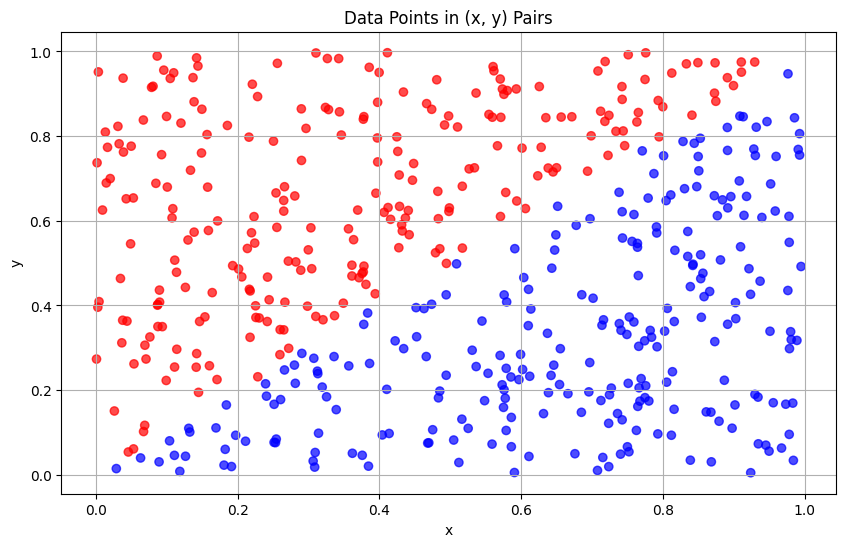

In [14]:
import matplotlib.pyplot as plt

# Plotting the data points
plt.figure(figsize=(10, 6))
colors = {0: 'red', 1: 'blue'}  # Assign color based on result
plt.scatter(data['x'], data['y'], c=data['result'].map(colors), alpha=0.7)
plt.title('Data Points in (x, y) Pairs')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.show()

 Implement the Perceptron Algorithm

In [15]:
import numpy as np

# Initialize weights
theta = np.array([1.0, 1.0])  # θ0

# Set learning rate
alpha = 0.5

# Iterate until convergence
t = 0
while True:
    theta_old = theta.copy()  # Store old theta for convergence check
    for index, row in data.iterrows():
        x_i = np.array([row['x'], row['y']])  # Feature vector
        result_i = row['result']  # Actual result

        # Compute the indicator function I
        I = 1 if np.dot(theta, x_i) >= 0 else 0

        # Update the weights
        theta += alpha * (result_i - I) * x_i
        
    t += 1

    # Check for convergence
    if np.array_equal(theta, theta_old):
        break

# Report final t and θ
print(f"Final number of steps (t): {t}")
print(f"Final value of θ at convergence: {theta}")


Final number of steps (t): 4
Final value of θ at convergence: [ 1.78149093 -1.78142407]


For Different Learning Rates

In [16]:
# List of different learning rates to test
learning_rates = [0.01, 0.1, 0.5, 1]
# Dictionary to store results for each learning rate
results = {}

# Loop through each learning rate
for alpha in learning_rates:
    # Reset theta (model parameters) for each learning rate
    theta = np.array([1.0, 1.0])  # Start with initial values for theta
    t = 0  # Initialize step counter

    while True:  # Continue until convergence
        theta_old = theta.copy()  # Keep a copy of the old theta to check for changes
        # Loop through each row in the data
        for index, row in data.iterrows():
            # Get the input features (x_i) from the current row
            x_i = np.array([row['x'], row['y']])
            # Get the actual result from the current row
            result_i = row['result']
            # Make a prediction (I) based on the current theta
            I = 1 if np.dot(theta, x_i) >= 0 else 0  # Predict 1 if the dot product is >= 0, else 0
            # Update theta based on the prediction error
            theta += alpha * (result_i - I) * x_i  # Adjust theta using the learning rate and error
            
        t += 1  # Increment the step counter
        
        # Check if theta has changed; if not, we have converged
        if np.array_equal(theta, theta_old):
            break  # Exit the loop if theta hasn't changed

    # Store the number of steps and final theta for this learning rate
    results[alpha] = (t, theta)

# Print the results for each learning rate
for alpha, (steps, final_theta) in results.items():
    print(f"Learning Rate: {alpha} | Steps to Convergence: {steps} | Final θ: {final_theta}")


Learning Rate: 0.01 | Steps to Convergence: 5 | Final θ: [ 0.27868806 -0.27832155]
Learning Rate: 0.1 | Steps to Convergence: 5 | Final θ: [ 0.48350347 -0.48398883]
Learning Rate: 0.5 | Steps to Convergence: 4 | Final θ: [ 1.78149093 -1.78142407]
Learning Rate: 1 | Steps to Convergence: 6 | Final θ: [ 4.21506157 -4.22483382]


Learning Rate Effects:

If α is very small (e.g., 0.01), the convergence process can be slow.

A moderate learning rate (such as 0.5) typically leads to faster convergence.

However, a larger learning rate (e.g., 1) can cause overshooting of the optimal solution.

**Problem 4**

Calculate Training Errors

In [17]:
import pandas as pd  # Import the pandas library for data manipulation
import numpy as np   # Import the numpy library for numerical operations

# Load the dataset from a CSV file
data = pd.read_csv(file_path)  # Read the CSV file into a DataFrame

# Extract features (input data) and labels (output data)
X = data[['x', 'y']].values  # Get the 'x' and 'y' columns as a NumPy array for features
y = data['result'].values     # Get the 'result' column as a NumPy array for labels

# Define different hypotheses (model parameters) to test
thetas = [
    np.array([0, -1]),        # Hypothesis 1
    np.array([0.65, -0.22]),  # Hypothesis 2
    np.array([0.9, -1]),      # Hypothesis 3
    np.array([0.7, -0.5]),    # Hypothesis 4
    np.array([0.5, -0.4])     # Hypothesis 5
]

# Function to calculate training errors for each hypothesis
def calculate_training_errors(X, y, thetas):
    training_errors = []  # List to store the training errors for each hypothesis
    
    # Loop through each hypothesis (theta)
    for theta in thetas:
        # Make predictions using the current hypothesis
        predictions = np.dot(X, theta) >= 0  # Calculate predictions (True/False)
        # Count how many predictions were wrong (misclassified)
        misclassified = np.sum(predictions != (y > 0))  # Compare predictions with actual labels
        # Calculate the training error as the fraction of misclassified samples
        training_error = misclassified / len(y)  # Divide by total number of samples
        training_errors.append(training_error)  # Add the error to the list
    
    return training_errors  # Return the list of training errors

# Calculate training errors for each hypothesis
training_errors = calculate_training_errors(X, y, thetas)

# Find the hypothesis with the least training error (best one)
best_index = np.argmin(training_errors)  # Get the index of the smallest error
best_training_error = training_errors[best_index]  # Get the value of the best training error

# Output the training errors for each hypothesis
for i, error in enumerate(training_errors):
    print(f"Training Error for θ{i+1}: {error:.4f}")  # Print each error with formatting

# Print the index of the best hypothesis and its training error
print(f"\nBest Hypothesis Index: {best_index + 1} with Training Error: {best_training_error:.4f}")


Training Error for θ1: 0.5100
Training Error for θ2: 0.3460
Training Error for θ3: 0.0380
Training Error for θ4: 0.1700
Training Error for θ5: 0.1080

Best Hypothesis Index: 3 with Training Error: 0.0380


Calculate Generalization Error Bounds

In [18]:
# Calculate generalization error bounds
n = len(y)  # Number of training examples
delta = 0.01

# Hoeffding bound calculations
lambda_1 = best_training_error - np.sqrt(np.log(2 / delta) / (2 * n))
lambda_2 = best_training_error + np.sqrt(np.log(2 / delta) / (2 * n))

# Output generalization error bounds
print(f"Generalization Error Bounds: [λ1: {lambda_1:.4f}, λ2: {lambda_2:.4f}]")


Generalization Error Bounds: [λ1: -0.0348, λ2: 0.1108]


Adjusting for Error Margin 

In [19]:
epsilon_h_star = 0.1  # Replace with the known value of ε(h*)
some_margin = 0.05

# Adjusting the bounds
lambda_1_adjusted = max(lambda_1, epsilon_h_star)
lambda_2_adjusted = min(lambda_2, epsilon_h_star + some_margin)  # Define some_margin as needed

print(f"Adjusted Generalization Error Bounds: [λ1: {lambda_1_adjusted:.4f}, λ2: {lambda_2_adjusted:.4f}]")


Adjusted Generalization Error Bounds: [λ1: 0.1000, λ2: 0.1108]


**Problem 5**

In [20]:
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt  

# Load the dataset from a CSV file
file_path = "C:\\Users\\Anagha\\Downloads\\Real_Estate.csv"  # Path to the dataset
data = pd.read_csv(file_path)  # Read the CSV file

# First few rows of dataset
print(data.head())

# Define the target variable and features
target = 'Y house price of unit area'  # The target variable we want to predict
features = ['X2 house age', 'X3 distance to the nearest MRT station', 
            'X4 number of convenience stores', 'X5 latitude', 'X6 longitude']  # Selected features for the model

# Function to perform train-test split
def split_data(data, split_ratio):
    """
    Splits the dataset into training and testing sets based on the given ratio.
    
    Parameters:
    data (DataFrame): The complete dataset.
    split_ratio (float): The proportion of the dataset to include in the test split.
    
    Returns:
    tuple: Training features, testing features, training labels, testing labels.
    """
    # Shuffle the data
    shuffled_data = data.sample(frac=1, random_state=42).reset_index(drop=True)
    split_index = int(len(data) * (1 - split_ratio))  # Calculate the split index
    train_data = shuffled_data[:split_index]          # Training data
    test_data = shuffled_data[split_index:]           # Testing data
    
    # Separate features and target variable
    train_X = train_data[features].values
    train_y = train_data[target].values
    test_X = test_data[features].values
    test_y = test_data[target].values
    
    return train_X, test_X, train_y, test_y  # Return the split data

   No  X1 transaction date  X2 house age  \
0   1             2012.917          32.0   
1   2             2012.917          19.5   
2   3             2013.583          13.3   
3   4             2013.500          13.3   
4   5             2012.833           5.0   

   X3 distance to the nearest MRT station  X4 number of convenience stores  \
0                                84.87882                               10   
1                               306.59470                                9   
2                               561.98450                                5   
3                               561.98450                                5   
4                               390.56840                                5   

   X5 latitude  X6 longitude  Y house price of unit area  
0     24.98298     121.54024                        37.9  
1     24.98034     121.53951                        42.2  
2     24.98746     121.54391                        47.3  
3     24.98746     121.54391  

Training Error (MSE): 67.4876
Testing Error (MSE): 127.7786


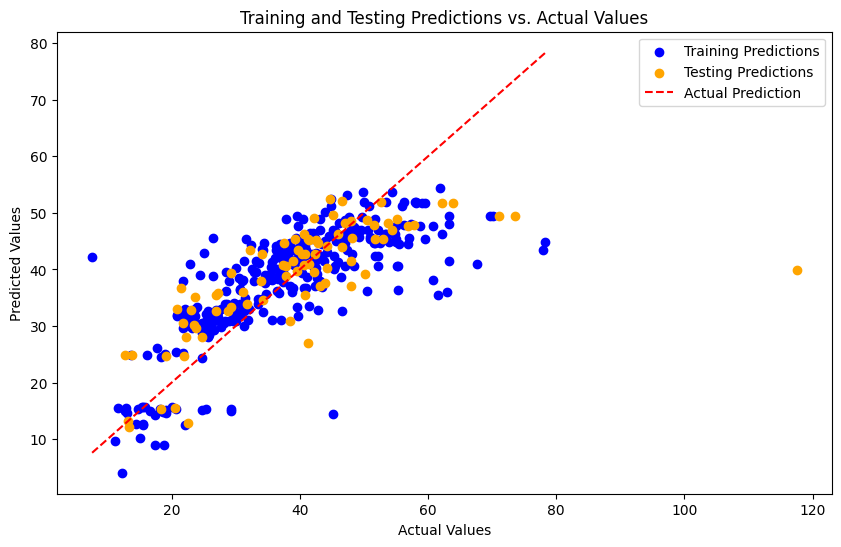

In [21]:
# Function to calculate mean squared error
def mean_squared_error(y_true, y_pred):
    """
    Calculates the mean squared error between true and predicted values.
    
    Parameters:
    y_true (array): True labels.
    y_pred (array): Predicted labels.
    
    Returns:
    float: Mean squared error.
    """
    return np.mean((y_true - y_pred) ** 2)  # Calculate MSE

# Function to perform linear regression
def linear_regression(X, y):
    """
    Performs linear regression using the normal equation.
    
    Parameters:
    X (array): Input features.
    y (array): Target variable.
    
    Returns:
    array: Coefficients of the linear regression model.
    """
    X_b = np.c_[np.ones((X.shape[0], 1)), X]                      # Add bias term (intercept)
    theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)  # Normal equation
    return theta_best                                             # Return the coefficients

# Function to make predictions
def predict(X, theta):
    """
    Makes predictions using the linear regression coefficients.
    
    Parameters:
    X (array): Input features.
    theta (array): Coefficients of the linear regression model.
    
    Returns:
    array: Predicted values.
    """
    X_b = np.c_[np.ones((X.shape[0], 1)), X]  # Add bias term (intercept)
    return X_b.dot(theta)                     # Return predictions

# Train-test split for 80:20 split
train_X, test_X, train_y, test_y = split_data(data, 0.2)  # Split data into training (80%) and testing (20%)

# Perform linear regression
theta = linear_regression(train_X, train_y)  # Get the coefficients

# Make predictions on training and testing sets
train_pred = predict(train_X, theta)  # Predictions for training set
test_pred = predict(test_X, theta)    # Predictions for testing set

# Calculate training and testing errors
train_error = mean_squared_error(train_y, train_pred)  # Training error
test_error = mean_squared_error(test_y, test_pred)     # Testing error

# Print the results
print(f'Training Error (MSE): {train_error:.4f}')  # Print training error
print(f'Testing Error (MSE): {test_error:.4f}')  # Print testing error

# Visualization: Plotting training and testing predictions
plt.figure(figsize=(10, 6))  # Set the size of the plot
plt.scatter(train_y, train_pred, label='Training Predictions', color='blue')  # Scatter plot for training predictions
plt.scatter(test_y, test_pred, label='Testing Predictions', color='orange')  # Scatter plot for testing predictions
plt.plot([min(train_y), max(train_y)], [min(train_y), max(train_y)], 'r--', label='Actual Prediction')  # Line for actual prediction
plt.title('Training and Testing Predictions vs. Actual Values')  # Set the title of the plot
plt.xlabel('Actual Values')  # Label for the x-axis
plt.ylabel('Predicted Values')  # Label for the y-axis
plt.legend()  # Show the legend
plt.show()  # Display the plot
